### **[기성언론] 뉴스 데이터/커뮤니티 크롤링 데이터 전처리**
- 빈값 NULL로 처리해서 제거
- 딕셔너리 값 매칭해서 변경 (한자어 같은 경우)
- 정규표현식으로 한글/영어/숫자만 남겨두기
- 띄어쓰기 교정 (pykospacing 패키지 활용)
- 토큰화 (토크나이저 비교)



In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
# Initial Setting (font, display)
!sudo apt-get install -y fonts-nanum # 글씨체 다운로드
!sudo fc-cache -fv # 폰트 리스트 갱신
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
import matplotlib
get_ipython().run_line_magic('config', "InlineBackend.figure_format='retina'") # 화질 보정

import os
import re
import pandas as pd
import numpy as np
import seaborn as sns

# NLP packages
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize
print('Ready')

In [ ]:
!pip3 install kss
!pip3 install git+https://github.com/haven-jeon/PyKoSpacing.git  # 한글 띄어쓰기(PyKoSpacing)

#### 1) 데이터 로드

In [ ]:
df = pd.read_excel('bigkinds.xlsx')
df = df[['일자', '언론사', '기고자', '제목', '본문', 'URL']]
df = df.rename(columns={"일자": "date", "언론사": "press", "기고자": "reporter",
                        "제목": "title", "본문": "content", "URL": "url"})
df['date'] = df['date'].astype(str)

for i in range(len(df)):
    df['date'][i] = str(df['date'][i])[:8]
    df['reporter'][i] = str(df['reporter'][i])[:3]
df.head(5)

,date,press,reporter,title,content,url
0,20220128,중앙일보,나운채,"정경심 유죄에 ""아직 판결문 읽나"" 고대생들 분노 넘어 자조",“이젠 정진택 총장도 답변하실 때가 됐습니다”\n지난 27일 고려대학교 학생 온라인...,https://www.joongang.co.kr/article/25044471
1,20211220,중앙일보,성지원,"""전 홍준표 지지자인데요"" 옥중 MB에 2030 편지 쏟아진다","“이명박 대통령님 안녕하세요, 저는 홍준표 국민의힘 의원 지지자인데 .” \n \n...",https://www.joongang.co.kr/article/25033800
2,20211222,머니투데이,류원혜,"고려대 갈 성적인데 경북대 가라는 엄마 ""사립대 지원할 돈 없다""",[머니투데이 류원혜 기자] 경제적 지원이 불가하다는 부모님의 반대로 고려대학교에 지...,http://news.moneytoday.co.kr/view/mtview.php?n...
3,20220225,헤럴드경제,김빛나,대학가 “올해도 비대면” 등록금 반환 핫이슈로,오는 3월 개강을 앞두고 대학가가 등록금 반환을 두고 고심하고 있다. 대학들은 지난...,http://biz.heraldcorp.com/view.php?ud=20220225...
4,20220225,헤럴드경제,김빛나,“올해도 비대면인데” 개강 앞둔 대학가 이슈 된 ‘등록금 반환’,[헤럴드경제=김빛나 기자] 오는 3월 개강을 앞두고 대학가가 등록금 반환을 두고 고...,http://biz.heraldcorp.com/view.php?ud=20220225...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      6 non-null      object
 1   press     6 non-null      object
 2   reporter  6 non-null      object
 3   title     6 non-null      object
 4   content   6 non-null      object
 5   url       6 non-null      object
dtypes: object(6)
memory usage: 416.0+ bytes


#### 2) 빈값 NULL값 처리

In [ ]:
# 1) check NULL value
# NULL값이 없더라도 빈 값 유무 확인하기 위해 모든 빈 값을 NULL로 변환하고, 다시 NULL값이 있는지 확인
df['content'].replace("", float("NaN"), inplace=True)
print(df['content'].isnull().values.any())

False


In [ ]:
df.dropna(inplace=True)

In [ ]:
# 길이 확인
print('총 샘플 수 :', len(df))

총 샘플 수 : 6


#### 3) 딕셔너리값 변경

In [ ]:
# 영문은 소문자로 변경
def lower(text):
    result = text.lower()
    return(result)

lower_corpus = []
for sent in df['content']:
    lower_corpus.append(lower(sent))

df['content_low'] = lower_corpus
df.head(3)

,date,press,reporter,title,content,url,content_low
0,20220128,중앙일보,나운채,"정경심 유죄에 ""아직 판결문 읽나"" 고대생들 분노 넘어 자조",“이젠 정진택 총장도 답변하실 때가 됐습니다”\n지난 27일 고려대학교 학생 온라인...,https://www.joongang.co.kr/article/25044471,“이젠 정진택 총장도 답변하실 때가 됐습니다”\n지난 27일 고려대학교 학생 온라인...
1,20211220,중앙일보,성지원,"""전 홍준표 지지자인데요"" 옥중 MB에 2030 편지 쏟아진다","“이명박 대통령님 안녕하세요, 저는 홍준표 국민의힘 의원 지지자인데 .” \n \n...",https://www.joongang.co.kr/article/25033800,"“이명박 대통령님 안녕하세요, 저는 홍준표 국민의힘 의원 지지자인데 .” \n \n..."
2,20211222,머니투데이,류원혜,"고려대 갈 성적인데 경북대 가라는 엄마 ""사립대 지원할 돈 없다""",[머니투데이 류원혜 기자] 경제적 지원이 불가하다는 부모님의 반대로 고려대학교에 지...,http://news.moneytoday.co.kr/view/mtview.php?n...,[머니투데이 류원혜 기자] 경제적 지원이 불가하다는 부모님의 반대로 고려대학교에 지...


In [ ]:
# 딕셔너리내 값 매칭해서 대체
replace_words = { "文" : "문제인 대통령",
                 "[머니투데이 류원혜 기자]" : ""}
replace_temp = {r'(\b){}(\b)'.format(k):r'\1{}\2'.format(v) for k, v in replace_words.items()}
df['content_low'] = df['content_low'].replace(replace_temp, regex=True)

#### 4) 정규표현식으로 한글/영어/숫자만 남겨두기

In [ ]:
# 2) 정규표현식 (특수기호/문자 제거)
# 텍스트 정제 함수: 한글과 숫자 이외의 문자는 모두 제거
def text_cleaning(text):
    hangulenglish = re.compile('[^A-Za-z0-9가-힣]')  # 한글/영어/숫자 제외한 모든 글자
    result = hangulenglish.sub(' ', str(text))  # 해당 글자 공백으로 대체
    return(result)

In [ ]:
cleaned_corpus = []
for sent in df['content']:
    cleaned_corpus.append(text_cleaning(sent))

df['content_clean'] = cleaned_corpus
df.head(3)

,date,press,reporter,title,content,url,content_low,content_clean
0,20220128,중앙일보,나운채,"정경심 유죄에 ""아직 판결문 읽나"" 고대생들 분노 넘어 자조",“이젠 정진택 총장도 답변하실 때가 됐습니다”\n지난 27일 고려대학교 학생 온라인...,https://www.joongang.co.kr/article/25044471,“이젠정진택총장도답변하실때가됐습니다”\n지난27일고려대학교학생온라인커뮤니티 ‘고파스...,이젠 정진택 총장도 답변하실 때가 됐습니다 지난 27일 고려대학교 학생 온라인 ...
1,20211220,중앙일보,성지원,"""전 홍준표 지지자인데요"" 옥중 MB에 2030 편지 쏟아진다","“이명박 대통령님 안녕하세요, 저는 홍준표 국민의힘 의원 지지자인데 .” \n \n...",https://www.joongang.co.kr/article/25033800,"“이명박대통령님안녕하세요, 저는홍준표국민의힘의원지지자인데 .” \n \n수감중인이명...",이명박 대통령님 안녕하세요 저는 홍준표 국민의힘 의원 지지자인데 수감...
2,20211222,머니투데이,류원혜,"고려대 갈 성적인데 경북대 가라는 엄마 ""사립대 지원할 돈 없다""",[머니투데이 류원혜 기자] 경제적 지원이 불가하다는 부모님의 반대로 고려대학교에 지...,http://news.moneytoday.co.kr/view/mtview.php?n...,[머니투데이류원혜기자] 경제적지원이불가하다는부모님의반대로고려대학교에지원조차하지못하게...,머니투데이 류원혜 기자 경제적 지원이 불가하다는 부모님의 반대로 고려대학교에 지...


#### 5) pykospacing으로 띄어쓰기 교정

In [ ]:
# 3) pykospacing으로 띄어쓰기 교정
from pykospacing import Spacing
spacing = Spacing()

spaced_corpus = []
for sent in df['content_clean']:
    spaced_corpus.append(spacing(sent))

df['content_spaced'] = spaced_corpus
df.head(3)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


,date,press,reporter,title,content,url,content_low,content_clean,content_spaced
0,20220128,중앙일보,나운채,"정경심 유죄에 ""아직 판결문 읽나"" 고대생들 분노 넘어 자조",“이젠 정진택 총장도 답변하실 때가 됐습니다”\n지난 27일 고려대학교 학생 온라인...,https://www.joongang.co.kr/article/25044471,“이젠정진택총장도답변하실때가됐습니다”\n지난27일고려대학교학생온라인커뮤니티 ‘고파스...,이젠 정진택 총장도 답변하실 때가 됐습니다 지난 27일 고려대학교 학생 온라인 ...,이 젠 정진택 총장도 답변 하실 때가 됐습니다 지난 27일 고려대학교 학생 온라인 ...
1,20211220,중앙일보,성지원,"""전 홍준표 지지자인데요"" 옥중 MB에 2030 편지 쏟아진다","“이명박 대통령님 안녕하세요, 저는 홍준표 국민의힘 의원 지지자인데 .” \n \n...",https://www.joongang.co.kr/article/25033800,"“이명박대통령님안녕하세요, 저는홍준표국민의힘의원지지자인데 .” \n \n수감중인이명...",이명박 대통령님 안녕하세요 저는 홍준표 국민의힘 의원 지지자인데 수감...,이명박 대통령님 안녕하세요 저는 홍준표 국민의 힘 의원 지지자인데 수감 중인 이명박...
2,20211222,머니투데이,류원혜,"고려대 갈 성적인데 경북대 가라는 엄마 ""사립대 지원할 돈 없다""",[머니투데이 류원혜 기자] 경제적 지원이 불가하다는 부모님의 반대로 고려대학교에 지...,http://news.moneytoday.co.kr/view/mtview.php?n...,[머니투데이류원혜기자] 경제적지원이불가하다는부모님의반대로고려대학교에지원조차하지못하게...,머니투데이 류원혜 기자 경제적 지원이 불가하다는 부모님의 반대로 고려대학교에 지...,머니투데이 류 원혜 기자 경제적 지원이 불가하다는 부모님의 반대로 고려대학교에 지원...


#### 6) 토크나이저 비교
: 토크나이저는 문장을 유의미한 토큰 단위로 변형해서 잘라주는 과정

In [ ]:
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

In [ ]:
cd Mecab-ko-for-Google-Colab/

/content/Mecab-ko-for-Google-Colab


In [ ]:
! bash install_mecab-ko_on_colab190912.sh

In [ ]:
from konlpy.tag import Okt, Komoran, Hannanum, Kkma

def get_tokenizer(tokenizer_name):
    if tokenizer_name == "komoran":
        tokenizer = Komoran()
    elif tokenizer_name == "okt":
        tokenizer = Okt()
    elif tokenizer_name == "kkma":
        tokenizer = Kkma()
    else:
        tokenizer = Mecab()
    return tokenizer

In [ ]:
df_sample = list(df['content_spaced'])[0]

tokenizer_komo = get_tokenizer("komoran")  # komoran
print(tokenizer_komo.morphs(df_sample), end = ' ')

['이', '제', 'ㄴ', '정진', '택', '총장', '도', '답변', '하', '시', 'ㄹ', '때', '가', '되', '었', '습니다', '지나', 'ㄴ', '27', '일', '고려대학교', '학생', '온라인', '커뮤니티', '고파스', '에', '올라오', 'ㄴ', '글', '의', '제목', '이', '다', '조국', '전', '법무부', '장관', '의', '딸', '조', '민', '씨', '의', '입학', '취소', '처분', '을', '촉구', '하', '는', '내용', '을', '담', '고', '있', '다', '같', '은', '날', '대법원', '은', '조', '전', '장관', '의', '부인', '정', '경심', '전', '동양', '대', '교수', '에', '대하', '아', '징역', '4년', '의', '실형', '을', '확정', '하', '았', '다', '해당', '글', '은', '28', '일', '오전', '까지', '1', '만', '2000', '여', '건의'] 

In [ ]:
tokenizer_okt = get_tokenizer("okt")  # okt
print(tokenizer_okt.morphs(df_sample), end = ' ')

['이', '젠', '정진', '택', '총장', '도', '답변', '하실', '때', '가', '됐습니다', '지난', '27일', '고려대학교', '학생', '온라인', '커뮤니티', '고파스', '에', '올라온', '글', '의', '제목', '이', '다', '조국', '전', '법무부', '장관', '의', '딸', '조', '민씨', '의', '입학', '취소', '처분', '을', '촉구', '하는', '내용', '을', '담고', '있다', '같은', '날', '대법원', '은', '조', '전', '장관', '의', '부인', '정경', '심', '전', '동양대', '교수', '에', '대해', '징역', '4년', '의', '실형', '을', '확정', '했다', '해당', '글', '은', '28일', '오전', '까지', '1만', '2000', '여', '건의'] 

In [ ]:
tokenizer_kkma = get_tokenizer("kkma")  # kkma
print(tokenizer_kkma.morphs(df_sample), end = ' ')

['이', '젠', '정진', '택', '총장', '도', '답변', '하', '시', 'ㄹ', '때', '가', '되', '었', '습니다', '지나', 'ㄴ', '27', '일', '고려대', '학교', '학생', '온라인', '커뮤니티', '이', '고', '파스', '에', '올르', '아', '오', 'ㄴ', '글', '의', '제목', '이', '다', '조국', '전', '법무부', '장관', '의', '딸', '조민', '씨', '의', '입학', '취소', '처분', '을', '촉구', '하', '는', '내용', '을', '담', '고', '있다', '같', '은', '날', '대법원', '은', '조', '전', '장관', '의', '부인', '정', '경심', '전', '동양', '대', '교수', '에', '대하', '어', '징역', '4', '년', '의', '실형', '을', '확정', '하', '었', '다', '해당', '글', '은', '28', '일', '오전', '까지', '1', '만', '2000', '여', '건의'] 

In [ ]:
# 토크나이저 육안으로 비교한 다음에 okt 토크나이저 사용하기로 결정

tokenizer_okt = get_tokenizer("okt")  # okt
evaluation_okt = []
for i in range(len(df)):
  evaluation_okt.append(tokenizer_okt.morphs(list(df['content_clean'])[i]))

df['content_tokenize'] = evaluation_okt
df.head(3)

,date,press,reporter,title,content,url,content_low,content_clean,content_spaced,content_tokenize
0,20220128,중앙일보,나운채,"정경심 유죄에 ""아직 판결문 읽나"" 고대생들 분노 넘어 자조",“이젠 정진택 총장도 답변하실 때가 됐습니다”\n지난 27일 고려대학교 학생 온라인...,https://www.joongang.co.kr/article/25044471,“이젠정진택총장도답변하실때가됐습니다”\n지난27일고려대학교학생온라인커뮤니티 ‘고파스...,이젠 정진택 총장도 답변하실 때가 됐습니다 지난 27일 고려대학교 학생 온라인 ...,이 젠 정진택 총장도 답변 하실 때가 됐습니다 지난 27일 고려대학교 학생 온라인 ...,"[이, 젠, 정진, 택, 총장, 도, 답변, 하실, 때, 가, 됐습니다, 지난, 2..."
1,20211220,중앙일보,성지원,"""전 홍준표 지지자인데요"" 옥중 MB에 2030 편지 쏟아진다","“이명박 대통령님 안녕하세요, 저는 홍준표 국민의힘 의원 지지자인데 .” \n \n...",https://www.joongang.co.kr/article/25033800,"“이명박대통령님안녕하세요, 저는홍준표국민의힘의원지지자인데 .” \n \n수감중인이명...",이명박 대통령님 안녕하세요 저는 홍준표 국민의힘 의원 지지자인데 수감...,이명박 대통령님 안녕하세요 저는 홍준표 국민의 힘 의원 지지자인데 수감 중인 이명박...,"[이명박, 대통령, 님, 안녕하세요, 저, 는, 홍준표, 국민, 의, 힘, 의원, ..."
2,20211222,머니투데이,류원혜,"고려대 갈 성적인데 경북대 가라는 엄마 ""사립대 지원할 돈 없다""",[머니투데이 류원혜 기자] 경제적 지원이 불가하다는 부모님의 반대로 고려대학교에 지...,http://news.moneytoday.co.kr/view/mtview.php?n...,[머니투데이류원혜기자] 경제적지원이불가하다는부모님의반대로고려대학교에지원조차하지못하게...,머니투데이 류원혜 기자 경제적 지원이 불가하다는 부모님의 반대로 고려대학교에 지...,머니투데이 류 원혜 기자 경제적 지원이 불가하다는 부모님의 반대로 고려대학교에 지원...,"[머니투데이, 류원혜, 기자, 경제, 적, 지원이, 불가하다는, 부모님, 의, 반대..."


In [ ]:
del df['content_low']
del df['content_clean']
del df['content_spaced']
df.head(5)

,date,press,reporter,title,content,url,content_tokenize
0,20220128,중앙일보,나운채,"정경심 유죄에 ""아직 판결문 읽나"" 고대생들 분노 넘어 자조",“이젠 정진택 총장도 답변하실 때가 됐습니다” \n 지난 27일 고려대학교 학생 온...,https://www.joongang.co.kr/article/25044471,"[이, 젠, 정진, 택, 총장, 도, 답변, 하실, 때, 가, 됐습니다, 지난, 2..."
1,20211220,중앙일보,성지원,"""전 홍준표 지지자인데요"" 옥중 MB에 2030 편지 쏟아진다","“이명박 대통령님 안녕하세요, 저는 홍준표 국민의힘 의원 지지자인데 .” \n \n...",https://www.joongang.co.kr/article/25033800,"[이명박, 대통령, 님, 안녕하세요, 저, 는, 홍준표, 국민, 의, 힘, 의원, ..."
2,20211222,머니투데이,류원혜,"고려대 갈 성적인데 경북대 가라는 엄마 ""사립대 지원할 돈 없다""",[머니투데이 류원혜 기자] 경제적 지원이 불가하다는 부모님의 반대로 고려대학교에 지...,http://news.moneytoday.co.kr/view/mtview.php?n...,"[머니투데이, 류, 원혜, 기자, 경제, 적, 지원이, 불가하다는, 부모님, 의, ..."
3,20220225,헤럴드경제,김빛나,대학가 “올해도 비대면” 등록금 반환 핫이슈로,오는 3월 개강을 앞두고 대학가가 등록금 반환을 두고 고심하고 있다. 대학들은 지난...,http://biz.heraldcorp.com/view.php?ud=20220225...,"[오는, 3월, 개강, 을, 앞두고, 대학가, 가, 등록금, 반환, 을, 두고, 고..."
4,20220225,헤럴드경제,김빛나,“올해도 비대면인데” 개강 앞둔 대학가 이슈 된 ‘등록금 반환’,[헤럴드경제=김빛나 기자] 오는 3월 개강을 앞두고 대학가가 등록금 반환을 두고 고...,http://biz.heraldcorp.com/view.php?ud=20220225...,"[헤럴드경제, 김, 빛나, 기자, 오는, 3월, 개강, 을, 앞두고, 대학가, 가,..."


In [ ]:
df.to_csv('bigkinds_preprocessed.csv')

In [ ]:
df_koreapas = pd.read_excel('/content/koreapas.xlsx')
df_koreapas = df_koreapas.rename(columns={"키워드": "keyword", "게시글 내용": "content", 
                                          "댓글_1": "comment_1", "댓글_2": "comment_2", "댓글_3": "comment_3"})

df_koreapas.head(5)

,keyword,content,comment_1,comment_2,comment_3
0,박성민,"이 시국 내가 박성민 교우님께 추천하는 진로\n""9급 공채 응시""",NaN,NaN,NaN
1,박성민,박성민씨 요즘 뭐하나요???\n여전히 꿀빠시나,NaN,NaN,NaN
2,박성민,박성민 밀어주는 문재앙이랑 신지예 영입한 윤석열이랑 차이점이 뭔가요?\n왜 하필 신...,NaN,NaN,NaN
3,박성민,청와머 박성민 차세대 100대 리더 선정됐네요ㅋㅋㅋ시사저널에서 뽑은거긴한데ㅋㅋ청년들...,조민도 넣지 왜\n,그런거치고도 비서관은 너무 말도안되는 인사였던거같아요ㅋㅋㅋ코로나 틈타서 꾸역꾸역 스...,이준석이 없네요? 이런 것도 부질없는게 머지포인트도 그 사태 안 일어났으면 머지 대...
4,박성민,"靑, 9개부처 작품을 “박성민 주도”… 네티즌 “노력 가로채기” 시끌\nhttp:/...",페미에 이어서 주작을 못하면 좌파를 못해인건가... \n,똑똑하며 정직한 좌파가 존재하지 못하는것과 같은 이유죠,이거완전 김정은 위원장 공적만들기랑 비슷 읍읍..


In [ ]:
cleaned_corpus = []
for sent in df_koreapas['content']:
    cleaned_corpus.append(text_cleaning(sent))

df_koreapas['content_clean'] = cleaned_corpus
df_koreapas.head(3)

,keyword,content,comment_1,comment_2,comment_3,content_clean
0,박성민,"이 시국 내가 박성민 교우님께 추천하는 진로\n""9급 공채 응시""",NaN,NaN,NaN,이 시국 내가 박성민 교우님께 추천하는 진로 9급 공채 응시
1,박성민,박성민씨 요즘 뭐하나요???\n여전히 꿀빠시나,NaN,NaN,NaN,박성민씨 요즘 뭐하나요 여전히 꿀빠시나
2,박성민,박성민 밀어주는 문재앙이랑 신지예 영입한 윤석열이랑 차이점이 뭔가요?\n왜 하필 신...,NaN,NaN,NaN,박성민 밀어주는 문재앙이랑 신지예 영입한 윤석열이랑 차이점이 뭔가요 왜 하필 신지...


### 고려대학교 온라인 커뮤니티 관련 기사 워드클라우드

In [ ]:
# konlpy로 명사만 추출하는 토큰화를 진행
stopwords = ['않다','에서','있다','없다','그렇다','아니다','것','이다','의','가','이','은','들', '주',
             '는','좀','잘','걍','과','도','을','를','으로','자','에','와','한','하다','휴','수' ,'일',
             '전','등','두','명','고','며','아아','대해',]

okt = Okt()
token = []
for sentence in df['content_clean']:
    temp_X = []
    temp_X = okt.nouns(sentence) # 명사 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    token.append(temp_X)
df['token'] = token
tokenizer = Tokenizer()
tokenizer.fit_on_texts(token)

In [ ]:
from collections import Counter 

# 단어 빈도 수 세어서 가장 빈도 높은 300개만 추출하는 함수 정의
def tokenizing(df):
    words = np.hstack(df['token'].values)
    word_count = Counter(words)
    input = dict(word_count.most_common(300))
    return input

In [ ]:
from wordcloud import WordCloud

# 토크나이징된 data frame 넣으면 워드클라우드 그려주는 함수 정의
def wcdraw(df, color):  
  df2 = tokenizing(df)
  fontpath = '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf'
  wordcloud = WordCloud(font_path = fontpath, max_words=100, colormap = color,
                      width=900,height=500, background_color ='white')
  wordcloud = wordcloud.generate_from_frequencies(df2) # 빈도에 따라서 워드클라우드 시각화
  plt.figure(figsize = (15 , 10))
  plt.axis("off")
  plt.imshow(wordcloud)

In [ ]:
from wordcloud import WordCloud

# 토크나이징된 data frame 넣으면 워드클라우드 그려주는 함수 정의
def wcdraw(df, color):  
  df2 = tokenizing(df)
  fontpath = '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf'
  wordcloud = WordCloud(font_path = fontpath, max_words=100, colormap = color,
                      width=900,height=500, background_color ='white')
  wordcloud = wordcloud.generate_from_frequencies(df2) # 빈도에 따라서 워드클라우드 시각화
  plt.figure(figsize = (15 , 10))
  plt.axis("off")
  plt.imshow(wordcloud)

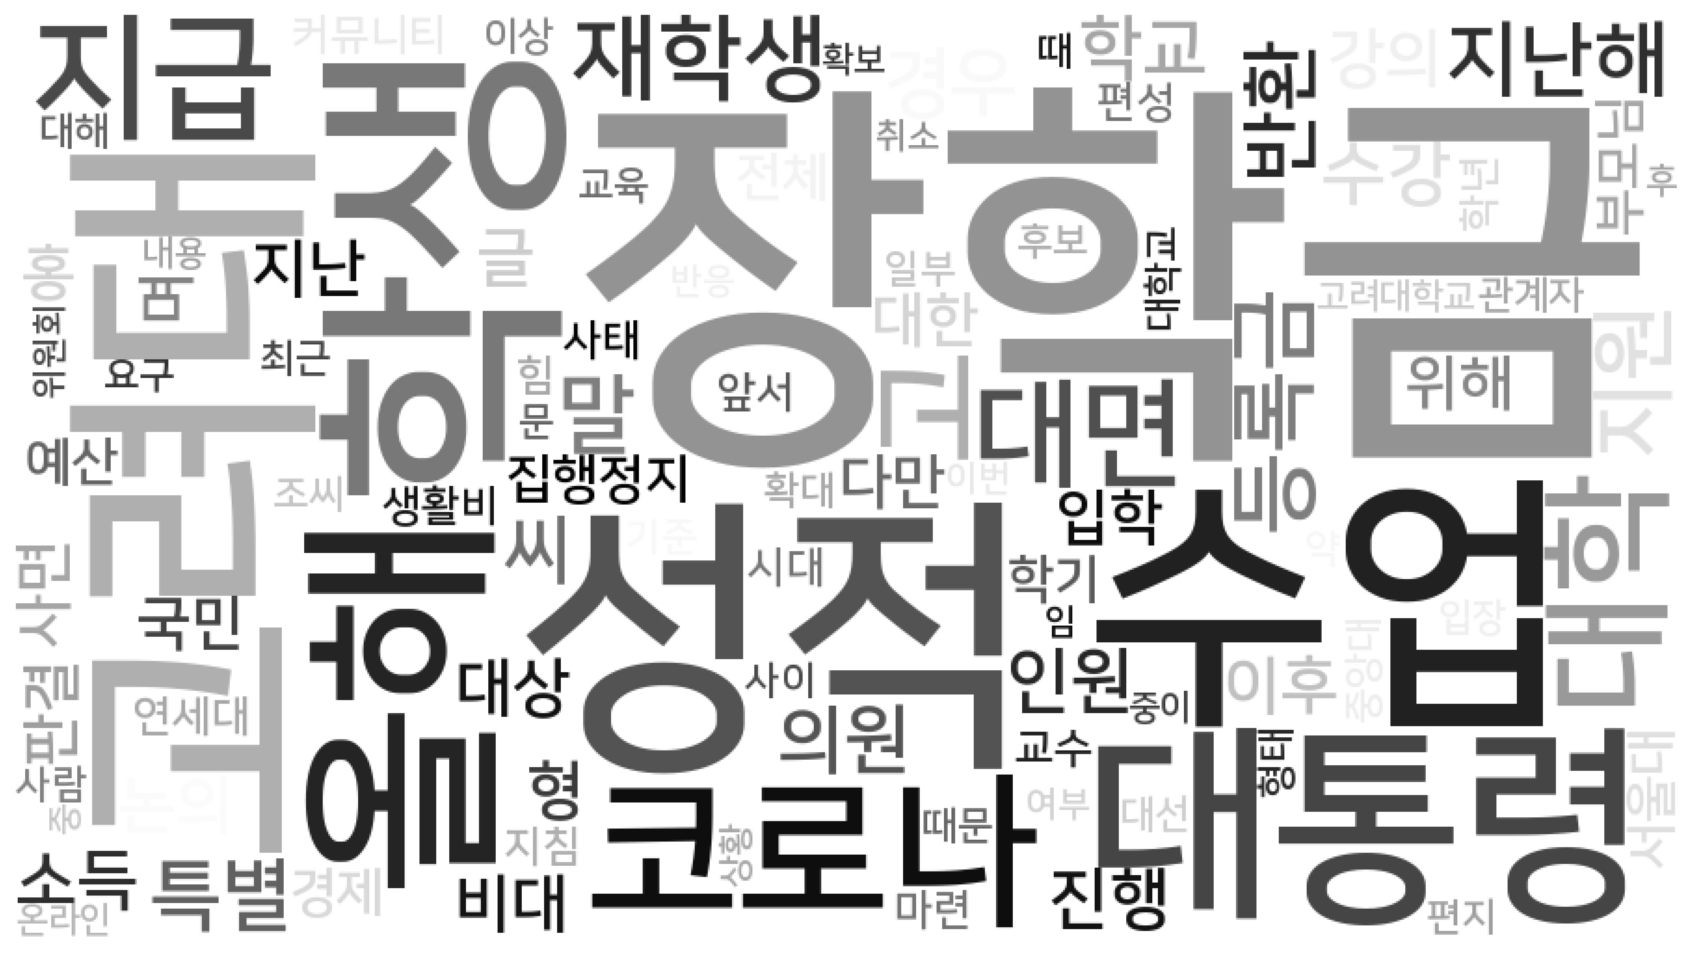

In [ ]:
wcdraw(df, 'binary')

### 박성민 청년비서관 관련 기사 워드클라우드

In [ ]:
# konlpy로 명사만 추출하는 토큰화를 진행
stopwords = ['않다','에서','있다','없다','그렇다','아니다','것','이다','의','가','이','은','들', '주',
             '는','좀','잘','걍','과','도','을','를','으로','자','에','와','한','하다','휴','수' ,'일',
             '비서','관','박','감','고','씨','달','더','등','며','내','직']
             
okt = Okt()
token = []
for sentence in df_naver['content_clean']:
    temp_X = []
    temp_X = okt.nouns(sentence) # 명사 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    token.append(temp_X)
df_naver['token'] = token
tokenizer = Tokenizer()
tokenizer.fit_on_texts(token)

In [ ]:
from collections import Counter 

# 단어 빈도 수 세어서 가장 빈도 높은 300개만 추출하는 함수 정의
def tokenizing(df):
    words = np.hstack(df_naver['token'].values)
    word_count = Counter(words)
    input = dict(word_count.most_common(100))
    return input

In [ ]:
from wordcloud import WordCloud

# 토크나이징된 data frame 넣으면 워드클라우드 그려주는 함수 정의
def wcdraw(df, color):  
  df2 = tokenizing(df)
  fontpath = '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf'
  wordcloud = WordCloud(font_path = fontpath, max_words=100, colormap = color,
                      width=900,height=500, background_color ='white')
  wordcloud = wordcloud.generate_from_frequencies(df2) # 빈도에 따라서 워드클라우드 시각화
  plt.figure(figsize = (15 , 10))
  plt.axis("off")
  plt.imshow(wordcloud)

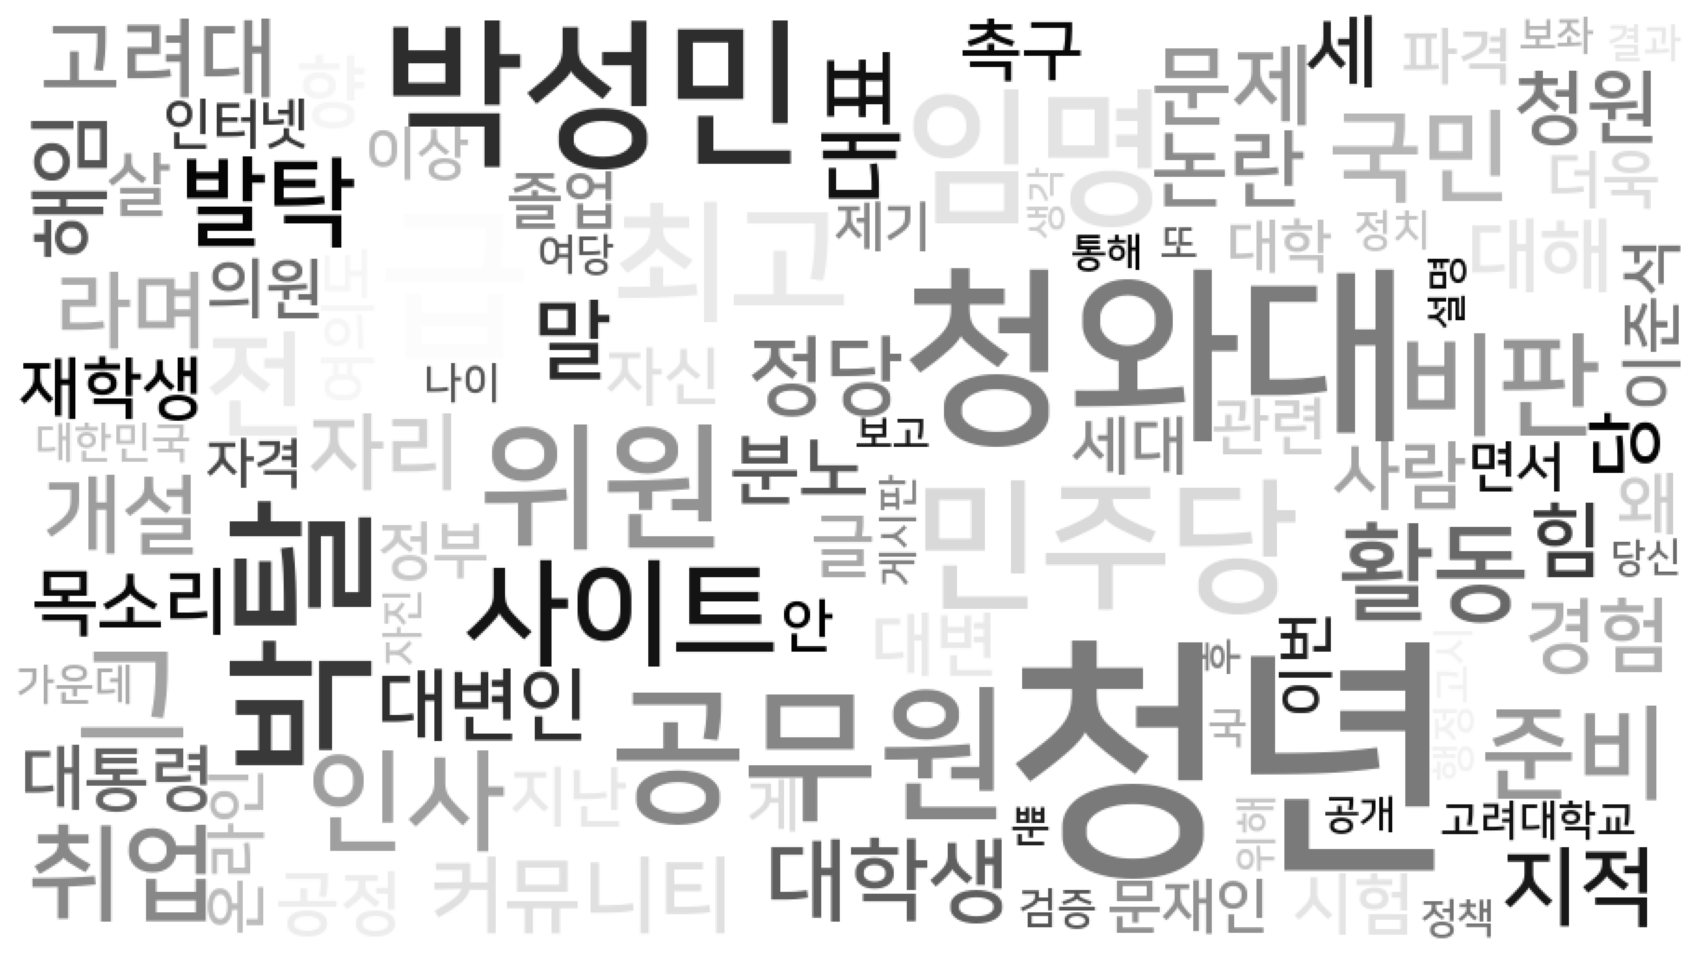

In [ ]:
wcdraw(df_naver, 'binary')

### 박성민 청년비서관 관련 고파스 게시글 워드클라우드

In [ ]:
!pip install konlpy

In [ ]:
from konlpy.tag import Okt, Komoran, Hannanum, Kkma

# konlpy로 명사만 추출하는 토큰화를 진행
stopwords = ['않다','에서','있다','없다','그렇다','아니다','것','이다','의','가','이','은','들', '주',
             '는','좀','잘','걍','과','도','을','를','으로','자','에','와','한','하다','휴','수' ,'일',
             '비서','관','박','감','고','씨','달','더','등','며','내','직','박성민','그','뭐']
             
okt = Okt()
token = []
for sentence in df_koreapas['content_clean']:
    temp_X = []
    temp_X = okt.nouns(sentence) # 명사 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    token.append(temp_X)
df_koreapas['token'] = token
tokenizer = Tokenizer()
tokenizer.fit_on_texts(token)

In [ ]:
from collections import Counter 

# 단어 빈도 수 세어서 가장 빈도 높은 300개만 추출하는 함수 정의
def tokenizing(df):
    words = np.hstack(df_koreapas['token'].values)
    word_count = Counter(words)
    input = dict(word_count.most_common(100))
    return input

In [ ]:
from wordcloud import WordCloud

# 토크나이징된 data frame 넣으면 워드클라우드 그려주는 함수 정의
def wcdraw(df, color):  
  df2 = tokenizing(df)
  fontpath = '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf'
  wordcloud = WordCloud(font_path = fontpath, max_words=100, colormap = color,
                      width=900,height=500, background_color ='white')
  wordcloud = wordcloud.generate_from_frequencies(df2) # 빈도에 따라서 워드클라우드 시각화
  plt.figure(figsize = (15 , 10))
  plt.axis("off")
  plt.imshow(wordcloud)

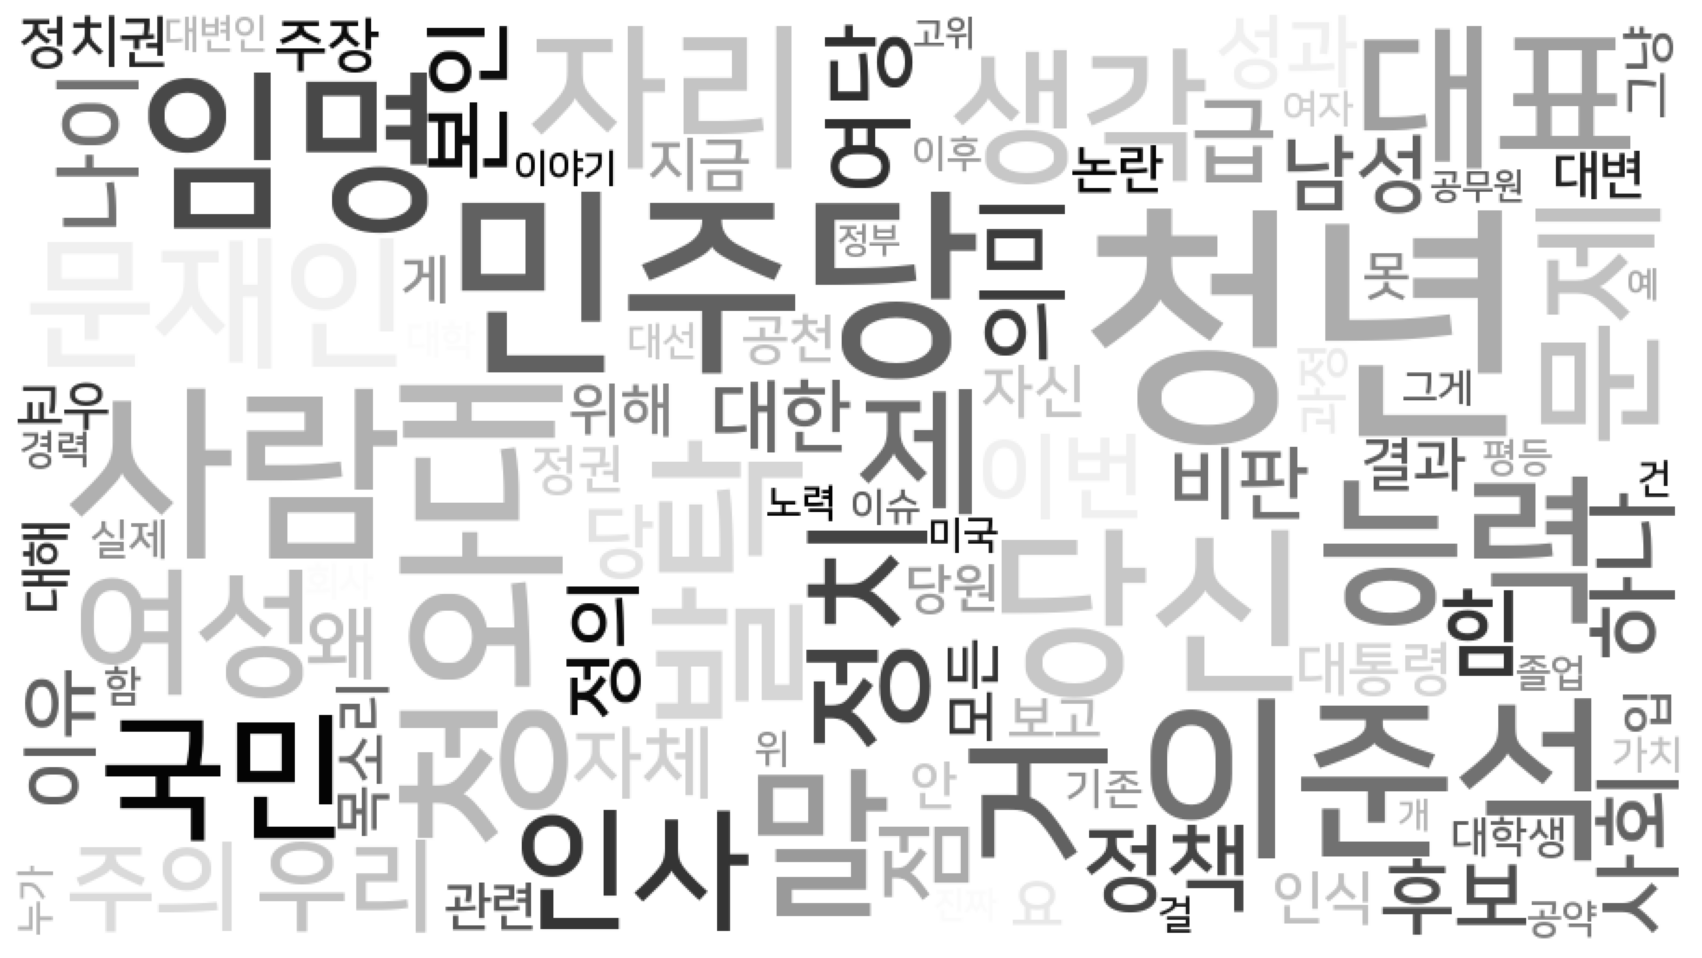

In [ ]:
wcdraw(df_koreapas, 'binary')